In [170]:
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from lxml import etree
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
import pandas as pd
import numpy as np
import datetime
import json
import threading
import asyncio
from asyncio_throttle import Throttler
import aiohttp
import tracemalloc
import time
import math

params = {
  'access_key': 'fc86254346a54a4fa6f26c220adbfab8'
}

header = {
    'user-agent': 'Mozilla/5.0'
}

# yahoo finance overriding the pandas datareader
yf.pdr_override()


## sp500 stocks 
all_tickers_xpath = '//span[text() = "S&P 500 component stocks"]/following::tbody[1]/tr/td[1]/a'
soup = BeautifulSoup(requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', headers=header).content, 'html.parser')
dom = etree.HTML(str(soup))

# find all tickers
all_tickers = [i.text for i in dom.xpath(all_tickers_xpath)]

<h3>Getting data for all sp500 stocks based on a certain start date</h3>

In [74]:
# def yfinance_get_data(tickers: list[str], start: datetime = datetime(2022, 1, 3)):
#     return pdr.get_data_yahoo(' '.join(tickers), start=start)

# data = yfinance_get_data(all_tickers, start = datetime(2021, 1, 1))

<h5>Reading CSV data of stock market and formatting</h5>

In [2]:
data = pd.read_csv('stockdata.csv')
above = [i.split('.')[0] for i in data.columns][1:]
below = data.iloc[0][1:]
data.set_index('Unnamed: 0', inplace=True)
data.columns = pd.MultiIndex.from_arrays([above, below])
data = data.drop('Date').rename_axis('Date')
data = data.iloc[1:,:]
data = data.stack().reset_index().set_index('Date').rename(columns={0 : 'Ticker'})

# it would be nice to have index as timestamp objects rather than
# just strings
def convert_to_datetime(s):
    s = s.split('-')
    yr = int(s[0])
    mo = int(s[1])
    day = int(s[2].split(' ')[0])

    return datetime.datetime(yr, mo, day)

data.index = list(map(convert_to_datetime, data.index))
data = data.rename_axis('Date')
data.head()

C:\Users\abhin\AppData\Local\Temp\ipykernel_24064\2506647805.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

,Ticker,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2021-01-04,A,117.03971099853516,118.63999938964844,120.08999633789062,117.11000061035156,118.94000244140625,2030700
2021-01-04,AAL,15.130000114440918,15.130000114440918,15.880000114440918,15.029999732971191,15.850000381469727,69732500
2021-01-04,AAP,147.68507385253906,157.33999633789062,159.57000732421875,155.9600067138672,157.89999389648438,849100
2021-01-04,AAPL,127.67998504638672,129.41000366210938,133.61000061035156,126.76000213623047,133.52000427246094,143301900
2021-01-04,ABBV,95.02763366699219,105.41000366210938,107.3499984741211,103.86000061035156,107.18000030517578,9523400


<h4>Unfortunately, 500 stock indicators is too much data, so we have to shorten this list to a smaller subset of stocks to study. We will focus on the top 25 stocks of SP500.</h4>

In [3]:
top_stocks = '''AAPL MSFT AMZN NVDA GOOGL BRK.A GOOG TSLA META XOM UNH JNJ JPM V PG MA CVX HD ABBV LLY MRK AVGO PEP KO PFE'''
top_stocks = top_stocks.split(' ')

# subset the dataset to the rows that contain the stock symbols
data_subset = data[data['Ticker'].isin(top_stocks)]

In [4]:
grouped = data_subset.groupby('Ticker')
# this example group will just be the sample dataset that
# we may do calculations with 
example_group = grouped.get_group(top_stocks[0])

In [5]:
# finanicial indicator functions
# note that these are indented to work with ONE key value
# ex. ONLY DATES means that we must group by stock ticker
# note: TICKERS will not make sense for these functions as keys

def check_series_numeric(column) -> bool:
    not_numeric = column.apply(pd.to_numeric, errors = 'coerce').isna().all()
    # if the data is not numeric, the test failed 
    return not not_numeric

def calculate_sma(column, period = 10):
    if not check_series_numeric(column):
        return column
    sma = column.rolling(period).mean()
    return pd.Series(sma, index= column.index, name = 'SMA')

def calculate_ema(column, period = 10):
    if not check_series_numeric(column):
        return column
    ema = column.ewm(span = period, min_periods = period - 1).mean()
    return pd.Series(ema, index = column.index, name = 'EMA')

# formula for RSI: 
'''
    let RS = average gain / average loss   
    RSI = 100 - 100 / (1 - RS)

    some things to look out for: 
        - using exponential weighted means on the average
            gains and losses made the RSI value much more
            sensitive and fluctuating more based on price
            changes
        - using simple averages made the RSI value more 
            smoothed out

    keyword argument options:
        - period: type int
        - use_exponential: type bool

'''
def calculate_rsi(column, *args, **kwargs):
    rsi = column.rolling(14).apply(lambda x: calculate_rsi_helper(x, *args, **kwargs)).astype(float)
    return pd.Series(rsi, index = column.index, name = 'RSI')

def calculate_rsi_helper(column, period = 14, use_exponential = False):
    if not check_series_numeric(column):
        return column 

    column = column.astype(float)
    # find differences in prices
    differences = column.diff() 

    # clip, but center off of zero value
    gain = differences.clip(lower = 0.01)
    loss = differences.clip(upper = -0.01)

    avg_gain = gain.mean()
    avg_loss = loss.mean()

    if use_exponential:
        # get the exponential weighted mean of the very last element in this current rolling window
        avg_gain = gain.ewm(span = period, min_periods = period - 1).mean()[-1]
        avg_loss = loss.ewm(span = period, min_periods = period - 1).mean()[-1]

    RS = avg_gain / avg_loss 
    RSI = 100 - 100 / (1 - RS)

    return RSI

'''
    MACD (moving average convergence/ divergence) shows the relationship
    between two exponential moving averages and comparing this to the 
    9-day EMA line 

    MACD = 12-period EMA - 26-period EMA 
    Signal = 9-period EMA - 26-period EMA
'''
def calculate_macd(column, long_period = 26, short_period = 12, signal_period = 9) -> tuple[object, object]:
    if not check_series_numeric(column):
        return column 
    
    ewm_short = example_group['Adj Close'].ewm(span = short_period, min_periods = 11).mean()
    ewm_long = example_group['Adj Close'].ewm(span = long_period, min_periods = 25).mean()

    # returns the macd 
    macd = (ewm_short - ewm_long).astype(float)

    # returns the signal line
    ewm_signal = example_group['Adj Close'].ewm(span = signal_period, min_periods = 8).mean()
    signal = (ewm_signal - ewm_long).astype(float)


    macd = pd.Series(macd, index = column.index, name = 'MACD')
    signal = pd.Series(signal, index = column.index, name = 'MACD-SIGNAL')
    return macd, signal


In [6]:
# TODO: apply this process concurrently or parallel if possible, then we can get
# even more data available to us
dataframes = []
for ticker in top_stocks:
    cur = None
    try:
        cur = grouped.get_group(ticker)
    except:
        print('skipped ticker:', ticker)
        continue 

    stock_data = cur['Adj Close']
    sma = calculate_sma(stock_data)
    ema = calculate_ema(stock_data)
    rsi = calculate_rsi(stock_data)
    macd, signal_macd = calculate_macd(stock_data)

    overall = pd.DataFrame([sma, ema, rsi, macd, signal_macd]).T
    res = pd.merge(cur, overall, on='Date')

    res = res.set_index([res.index, res['Ticker']]).drop('Ticker', axis = 1)

    dataframes.append(res)
    


skipped ticker: BRK.A


In [7]:
data = pd.concat(dataframes, axis = 0)

In [8]:
data

,,Adj Close,Close,High,Low,Open,Volume,SMA,EMA,RSI,MACD,MACD-SIGNAL
Date,Ticker,,,,,,,,,,,
2021-01-04,AAPL,127.67998504638672,129.41000366210938,133.61000061035156,126.76000213623047,133.52000427246094,143301900,NaN,NaN,NaN,NaN,NaN
2021-01-05,AAPL,129.2586212158203,131.00999450683594,131.74000549316406,128.42999267578125,128.88999938964844,97664900,NaN,NaN,NaN,NaN,NaN
2021-01-06,AAPL,124.90755462646484,126.5999984741211,131.0500030517578,126.37999725341797,127.72000122070312,155088000,NaN,NaN,NaN,NaN,NaN
2021-01-07,AAPL,129.16983032226562,130.9199981689453,131.6300048828125,127.86000061035156,128.36000061035156,109578200,NaN,NaN,NaN,NaN,NaN
2021-01-08,AAPL,130.2847137451172,132.0500030517578,132.6300048828125,130.22999572753906,132.42999267578125,105158200,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14,PFE,41.189999,41.189999,41.709999,40.93,41.509998,20613300,41.365,41.255713,61.868660,2.980509,3.526012
2023-04-17,PFE,41.18,41.18,41.279999,40.959999,41.119999,17608600,41.403,41.241947,65.507987,2.969431,3.527161
2023-04-18,PFE,40.549999,40.549999,41.330002,40.529999,41.279999,18541500,41.323,41.116139,53.527950,3.025830,3.631906


In [9]:
# creating the csv file for stock price predictions
# data.to_csv('../predictions/stock_data_all.csv')

<h4>Transforming indicators to give us values that are a bit more useful</h4>

In [155]:
# plt.plot(stock_data['Adj Close'].astype(float))
stock_data = data.reset_index().set_index('Date').query('Ticker == "AAPL"')

def plot_period(offset_start = -100, offset_end = 0):

    temp_data = stock_data.iloc[offset_start:offset_end if offset_end != 0 else None]

    fig, ax = plt.subplots(2, 1, figsize = (10,8))
    ax[0].plot(temp_data['Adj Close'].astype(float))
    ax[1].plot(temp_data['MACD'].astype(float))
    ax[1].plot(temp_data['MACD-SIGNAL'].astype(float))

# plot_period(-100, 0)

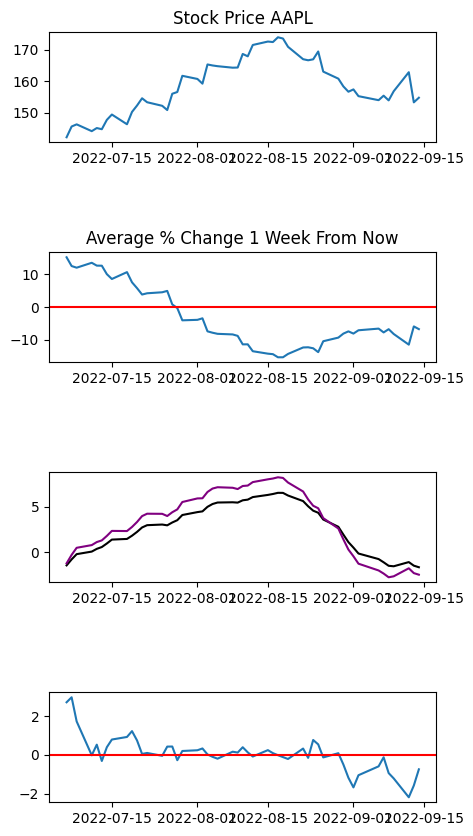

In [203]:
avg_price_days_between = 15
avg_price_period = 30 
macd_indicator_slope_period = 10


# the first thing i'm doing is calculating the average price for the period
# that comes after a certain date, and this code represents the following...

# let x be = [.....X.....]
# average calculated from something like = [....X...[..(average)..]....]
def average_price_after_period(x, days_between = 5, period = 10):

    def calculate_average(x, period):
        return np.mean(x[0:period]) 
    return x[::-1].rolling(days_between + period + 1).apply(lambda x: calculate_average(x, period))[::-1]

new_prices = average_price_after_period(stock_data['Adj Close'], days_between=avg_price_days_between, period=avg_price_period)

percent_changes = (new_prices.astype(float) - stock_data['Adj Close'].astype(float)) / stock_data['Adj Close'].astype(float) * 100
stock_data['Percent_Changes'] = percent_changes


# now, we will derive a new sort of variable for our MACD lines so our data will
# have better meaning. The MACD indicator will essentially give us more positive
# values whenever the signal line crosses above the MACD, and vice-versa for 
# negative values
def macd_new_indicator(macd_differences, slope_period):
    # here, we will make the indicator and then visualize everything together at once
    def tanh_activation_function(x, factor = 1):
        if not x:
            return None 
        return 1 - (math.tanh(factor * x) ** 2)

    def slope_from_past(x, period = 5, data = stock_data):
        start = x[0]
        end = x[1]

        if not start or not end:
            return None 
        else:
            return (end - start) / period

    signal = [tanh_activation_function(i) for i in macd_differences]

    period = 10
    slope = macd_differences.rolling(period).apply(lambda x: slope_from_past(x, period=slope_period))

    new_macd_indicator = signal * slope * 100

    return new_macd_indicator

# remember: always do signal - macd for a better explanation of what's going on 
macd_differences = stock_data['MACD-SIGNAL'] - stock_data['MACD']
new_macd_indicator = macd_new_indicator(macd_differences, macd_indicator_slope_period)

stock_data['MACD-NEW'] = new_macd_indicator

# visualize the results
fig, ax = plt.subplots(4, 1, figsize=(5, 10))

start = -200
end = -150

ax[0].plot(stock_data['Adj Close'][start:end].astype(float))
ax[0].set_title('Stock Price AAPL')
ax[1].plot(stock_data['Percent_Changes'][start:end].astype(float))
ax[1].set_title('Average % Change 1 Week From Now')
ax[1].axhline(0, color = 'red')
ax[2].plot(stock_data['MACD'][start:end].astype(float), color = 'black')
ax[2].plot(stock_data['MACD-SIGNAL'][start:end].astype(float), color = 'purple')
ax[3].plot(stock_data['MACD-NEW'][start:end].astype(float))
ax[3].axhline(0, color = 'red', linestyle='-')

fig.subplots_adjust(hspace=1)

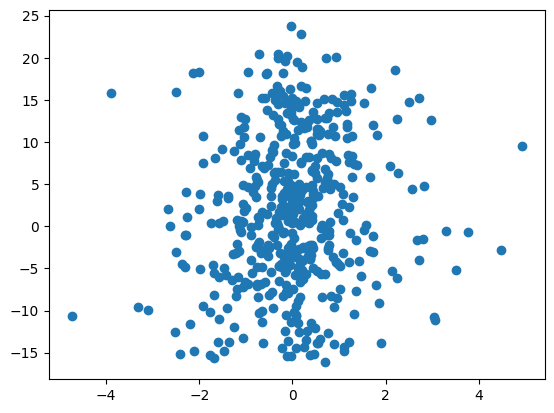

In [205]:
def macd_new_signal_plot(stock_data):
    temp = stock_data.dropna()

    plt.scatter(x = temp['MACD-NEW'], y = temp['Percent_Changes'])

macd_new_signal_plot(stock_data)

In [202]:
stock_data.to_csv('../predictions/aapl_stock.csv')

In [201]:
stock_data

,Ticker,Adj Close,Close,High,Low,Open,Volume,SMA,EMA,RSI,MACD,MACD-SIGNAL,Percent_Changes,MACD-NEW
Date,,,,,,,,,,,,,,
2021-01-04,AAPL,127.67998504638672,129.41000366210938,133.61000061035156,126.76000213623047,133.52000427246094,143301900,NaN,NaN,NaN,NaN,NaN,3.362966,NaN
2021-01-05,AAPL,129.2586212158203,131.00999450683594,131.74000549316406,128.42999267578125,128.88999938964844,97664900,NaN,NaN,NaN,NaN,NaN,3.112729,NaN
2021-01-06,AAPL,124.90755462646484,126.5999984741211,131.0500030517578,126.37999725341797,127.72000122070312,155088000,NaN,NaN,NaN,NaN,NaN,7.194318,NaN
2021-01-07,AAPL,129.16983032226562,130.9199981689453,131.6300048828125,127.86000061035156,128.36000061035156,109578200,NaN,NaN,NaN,NaN,NaN,3.890144,NaN
2021-01-08,AAPL,130.2847137451172,132.0500030517578,132.6300048828125,130.22999572753906,132.42999267578125,105158200,NaN,NaN,NaN,NaN,NaN,3.531229,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14,AAPL,165.210007,165.210007,166.320007,163.820007,164.589996,49337200,163.882001,162.975903,65.113256,2.980509,3.526012,NaN,0.947760
2023-04-17,AAPL,165.229996,165.229996,165.389999,164.029999,165.089996,41516200,163.915001,163.385738,66.935138,2.969431,3.527161,NaN,0.187595
2023-04-18,AAPL,166.470001,166.470001,167.410004,165.649994,166.100006,49923000,163.945001,163.946513,63.898393,3.025830,3.631906,NaN,-0.742828


<h3>Using Pushshift API to get Sentiment Data from Reddit</h3>
<h3>NOT DOING THIS ANYMORE: rate limits make it very hard to get all the data that is needed</h3>

<ol>
    <li>Each entry of stocks are associated with the current day and the ticker symbol</li>
    <li>We may search through top comments or posts through Pushshift to search for stock ticker mentions per day and stock</li>
    <li>In order to load numerous http requests, we are using asyncio for concurrently loading data</li>
</ol>

In [240]:
# function to convert date time string into epoch format for pushshift
def str_index_to_epoch(s: str, days_after = 1) -> tuple[int, int]:
    s = str(s)
    s = s.split('-')
    yr = int(s[0])
    mo = int(s[1])
    day = int(s[2].split(' ')[0])
    # the yahoo finance data is given as EST time
    today = datetime.datetime(yr, mo, day)
    tomorrow = today + relativedelta(days = days_after)

    print('today', today, 'tomorrow', tomorrow, 'after', days_after)
    return (int(today.timestamp()), int(tomorrow.timestamp()))

def index_str_to_datetime(s: str, split='-'):
    # get anything that is before a space, to isolate the current search thingy
    s = s.split(' ')[0]
    vals = [int(i) for i in s.split(split)]

    return datetime.datetime(year=vals[0], month=vals[1], day=vals[2])

In [341]:
def get_link(X, subreddit = 'stocks', size = 25, days_after = 1):
    subreddit = subreddit
    ticker = X['Ticker']
    date_after, date_before = str_index_to_epoch(X.name, days_after=days_after)
    size = size

    req_string_reddit_comments = f'https://api.pushshift.io/reddit/search/comment/?q={ticker}&subreddit={subreddit}&size={size}&after={date_after}&before={date_before}&fields=body&frequency=day'
    
    return req_string_reddit_comments

def create_query_link(argument_dict, type = 'comment'):
    args = []
    for argument in argument_dict:
        args.append(argument)
        args.append('=')
        args.append(argument_dict[argument])
        args.append('&')

        query_string = ''.join(args[:-1])
    return f'https://api.pushshift.io/reddit/{type}/search/?{query_string}'


we can simply use the api to get all date ranges for the stock market in one link

In [371]:
# using ticker aapl as the current symbol
stock_data = data.query('Ticker == "AAPL"').reset_index().set_index('Date')
start_date, end_date = stock_data.iloc[0].name, stock_data.iloc[-1].name
start_date, end_date = index_str_to_datetime(str(start_date)), index_str_to_datetime(str(end_date))

period = (end_date - start_date).days
print(period, 'days to search for')

args = {
    'q': 'AAPL',
    'subreddit': 'stocks',
    'after': str(int(start_date.timestamp())),
    'before': str(int((end_date.timestamp()))),
    'size': str(500),
    'count': str(50),
    'sort':'created_utc',
    'sort_type': 'asc'
}

link = create_query_link(args)
print(link)

836 days to search for
https://api.pushshift.io/reddit/comment/search/?q=AAPL&subreddit=stocks&after=1609740000&before=1681966800&size=500&count=50&sort=created_utc&sort_type=asc


In [425]:
import threading 

dataframes = []

def roll_apply(window):
    print(window)

def add_to_dataframes(start, end, counter):
    after = index_str_to_datetime(str(start)).timestamp()
    before = index_str_to_datetime(str(end)).timestamp()

    args = {
    'q': 'AAPL',
    'subreddit': 'stocks',
    'after': str(int(after)),
    'before': str(int(before)),
    'size': str(500),
    'count': str(50),
    'sort':'created_utc',
    'sort_type': 'asc'
    }

    print('request #', counter)

    r = requests.get(create_query_link(args))
    result = json.loads(r.text)['data']
    dataframes.append(pd.DataFrame(result))

counter = 1
period = 30

cur_threads = []
for i in range(0, len(stock_data), period):
    start = stock_data.iloc[i].name
    end = stock_data.iloc[min(len(stock_data)-1,i + period)].name

    thread = threading.Thread(target=add_to_dataframes, args=(start, end, counter))
    thread.start()
    cur_threads.append(thread)

    time.sleep(2)

    counter += 1

for thread in cur_threads:
    thread.join()

request # 1
request # 2
request # 3
request # 4
request # 5
request # 6
request # 7
request # 8
request # 9
request # 10
request # 11
request # 12
request # 13
request # 14
request # 15
request # 16
request # 17
request # 18
request # 19
request # 20


In [426]:
sentiment_data = pd.concat(dataframes, axis = 0)
sentiment_data = sentiment_data[['body', 'utc_datetime_str']]
sentiment_data['date'] = [index_str_to_datetime(s) for s in sentiment_data['utc_datetime_str']]
sentiment_data['date'] = [convert_to_datetime(str(s)) for s in sentiment_data['date']]

sentiment_data

,body,utc_datetime_str,date
0,You're gonna wanna add PLTR by the EOY. Other...,2021-02-17 05:58:16,2021-02-17
1,I started a 1000$ (1087$ to be exact) trading ...,2021-02-17 05:56:23,2021-02-17
2,AAPL and MSFT are like bank accounts with 20-4...,2021-02-17 05:33:25,2021-02-17
3,Message unclear. YOLO life savings on AAPL at ...,2021-02-17 05:31:52,2021-02-17
4,Leaps on AAPL are pricey. If you’re going in ...,2021-02-17 05:27:41,2021-02-17
...,...,...,...
94,I don’t mean market consensus “undeniable winn...,2023-04-11 13:48:42,2023-04-11
95,I had 6680 shares of Waste Management in 2012 ...,2023-04-11 13:17:25,2023-04-11
96,"Portfolio 1: \nCSPX, VXUS \nAAPL, ABNB, AZN,...",2023-04-11 12:24:42,2023-04-11
97,AAPL. Strong buybacks and good dividend backed...,2023-04-11 11:21:45,2023-04-11


In [427]:
len(np.unique(sentiment_data['date']))

478

In [438]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment_obj = SentimentIntensityAnalyzer()

def clean_str(s: str):
    return s.strip().replace('\n', ' ')

compound_sentiment_scores = [sentiment_obj.polarity_scores(clean_str(s))['compound'] for s in sentiment_data['body']]


In [440]:
sentiment_data['sentiment_score'] = compound_sentiment_scores

In [441]:
sentiment_data.to_csv('../predictions/sentiment_aapl.csv')